## Lesson 6: Bias and Variance / Hyperparameter and Validation Set
Readings:
- [5.3 Hyperparameters and Validation Sets](https://www.deeplearningbook.org/contents/ml.html) (p. 118)
- [5.4.4 Trading oﬀ Bias and Variance to Minimize Mean Squared Error](https://www.deeplearningbook.org/contents/ml.html) (p. 127)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set()

from scripts_09 import *

pi = np.pi

Lesson structure:
- Bias and its correspondence to underfitting
- Variance and its correspondence to overfitting
- Hyperparameter optimization
- Validation sets

In [27]:
def format_plot(title):
    fontdict={
        'fontsize': 15
    }
    plt.gcf().set_size_inches(8, 6)
    ax = plt.gca()
    ax.set_xlabel('$X$', fontdict=fontdict)
    ax.set_ylabel('$f(X)$', fontdict=fontdict)
    ax.set_title(title, fontdict=fontdict)

---

Over- and under-fitting are two undesirable extremes in the spectrum of how well a model can [generalize](https://towardsdatascience.com/understand-neural-networks-model-generalization-7baddf1c48ca).
Both results in under-performance relative to optimal behavior.

While we have discussed how to diagnose and remedy these issues, it is also important to understand their underlying causes.
We have explained that overfitting occurs when the model capacity is too high, and underfitting occurs when it is too low.
This happens because of two types of error--**bias** and **variance**--and their relationship to model capacity.

Let's start by creating some sample data and training a regression model.

---

In [28]:
raise NotImplementedError()

NotImplementedError: 

---

We've already seen that by changing the number of polynomial terms, we can increase our **model capacity**, and vice-versa.

We have also discussed that in order to evaluate the performance of our model, we require splitting our data into training and testing subsets.
By calculating how well our model can **generalize** to our test set, we can judge whether we are in an under- or over-fitting regime.

Let's try this

---

In [29]:
raise NotImplementedError()

NotImplementedError: 

---

This raises new questions: why is this happening, and how can we formalize it?

Underfitting can be explained by **bias**. This is defined as the consistent, expected error of your model, independed of the data sample used for training.

To illustrate, take the following function:

---

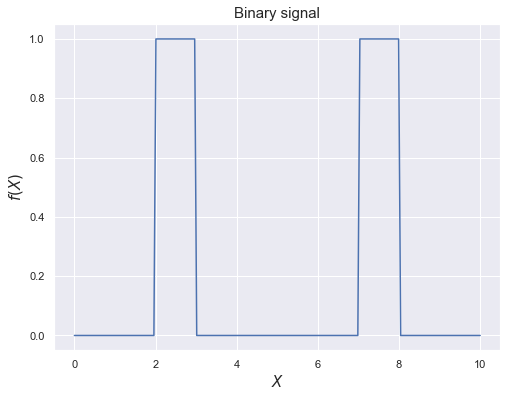

In [30]:
def f(x):
    return (((x>=2) & (x<=3)) | ((x>=7) & (x<=8))).astype(np.int32)
    
plt.plot(np.linspace(0,10,200), f(np.linspace(0,10,200)))
format_plot('Binary signal')

---

Let's try to model this distribution using K-Nearest-Neighbors.

First, we sample some data from the distribution.

---

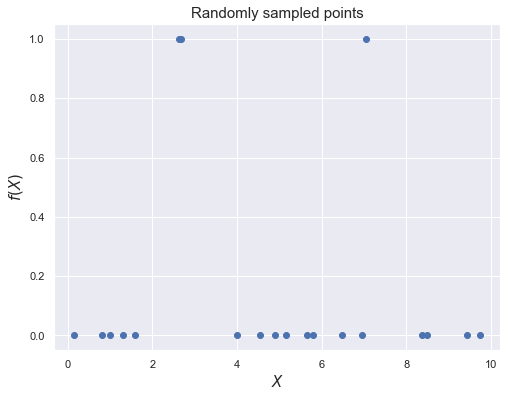

In [33]:
X = np.random.random((20))*10

plt.scatter(X, f(X))
format_plot('Randomly sampled points')

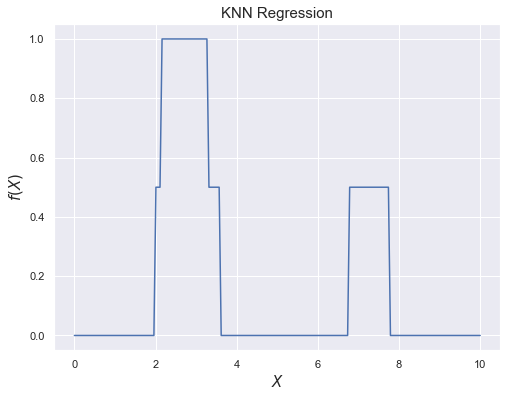

In [40]:
from sklearn import neighbors

KNN_model = neighbors.KNeighborsRegressor(2)
KNN_model.fit(X[...,None], f(X)[...,None])

predictions = KNN_model.predict(np.linspace(0,10,200)[...,None])
plt.plot(np.linspace(0,10,200), predictions[:,0])
format_plot('KNN Regression')

In [ ]:
p